In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
import tensorflow as tf

In [4]:
from agnfinder.tf_sampling import deep_emulator

In [5]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [78]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']
# save_dir = 'results/emulated_sampling/real'
save_dir = '/media/mike/beta/agnfinder_results/uk_ir_selection_577'

galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert galaxy_locs

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        f = h5py.File(galaxy_loc, mode='r')
        galaxies.append({
            'samples': np.squeeze(f['samples'][:10:]),
            'name': galaxy_loc.split('_')[-2],
            'true_observations': np.squeeze(f['true_observations'][...]),
            'redshift': f['redshift'][...]
        })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [79]:
galaxies[0]['true_observations'].shape

(12,)

### Load parquet for labels

In [80]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
labels = pd.read_parquet('data/uk_ir_selection_577.parquet')

In [81]:
# labels.columns.values

In [82]:
labels['most_likely_rf_class'] = labels[rf_cols].apply(lambda x: rf_classes[np.argmax(x.values)], axis=1)
labels['most_likely_rf_class'].value_counts()

qso            150
passive        150
starforming    150
agn            107
starburst       20
Name: most_likely_rf_class, dtype: int64

In [83]:
label_dict = dict(zip(labels.index, labels['most_likely_rf_class'].values))
# label_dict

In [84]:
for galaxy in galaxies:
    galaxy['rf_class'] = label_dict[int(galaxy['name'])]

In [85]:
# galaxy_locs

### How do we do at reproducing observations?

In [86]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)

In [87]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])



In [100]:
galaxy['redshift']  # woops, this isn't normalised!

array([2.2785573], dtype=float32)

(10, 8)
(10, 8)
(10, 8)
(10, 8)


/media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


(10, 8)
(10, 8)
(10, 8)
(10, 8)
(10, 8)
(10, 8)


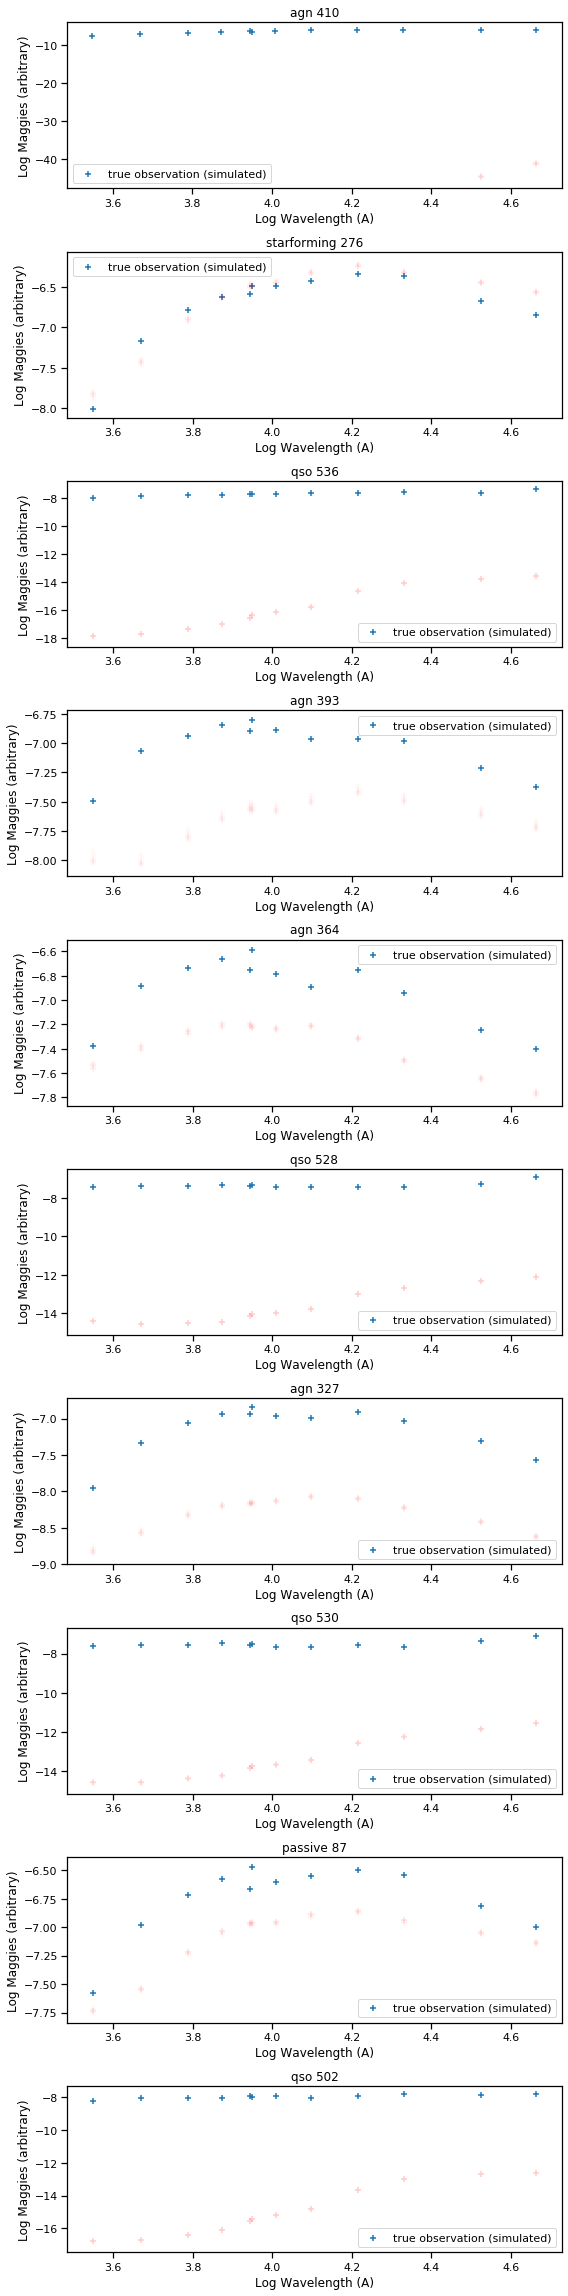

In [99]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

for n, galaxy in enumerate(galaxies[:n_galaxies]):
    ax = axes[n]
    true_photometry = galaxy['true_observations']
    redshifts = np.array([galaxy['redshift'] for _ in range(len(galaxy['samples']))])
#     print(redshifts.shape)
#     print(galaxy['samples'].shape)
    params_with_redshift = np.concatenate((redshifts, galaxy['samples']), axis=1)
#     print(params_with_redshift.shape)
    sample_photometry = deep_emulator.denormalise_photometry(emulator(params_with_redshift)).numpy()
    np.random.shuffle(sample_photometry)

    ax.scatter(np.log10(wavelengths), np.log10(true_photometry), label='true observation (simulated)', marker='+')
    for trace in sample_photometry[:100]:
        ax.scatter(np.log10(wavelengths), np.log10(trace), color='r', marker='+', alpha=0.02)
    ax.legend()
    ax.set_title('{} {}'.format(galaxy['rf_class'], galaxy['name']))
    ax.set_ylabel('Log Maggies (arbitrary)')
    ax.set_xlabel('Log Wavelength (A)')
    
plt.tight_layout()

In [ ]:
galaxy['rf_class']

In [56]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [57]:
raw_df.head()

,index,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,rf_class
0,0,0.951055,0.051142,0.116833,0.363659,0.004917,0.151753,0.134432,passive
1,1,0.954810,0.055431,0.109020,0.360338,0.017608,0.158962,0.132010,passive
2,2,0.951539,0.047821,0.113125,0.359642,0.028938,0.160196,0.131671,passive
3,3,0.956801,0.048646,0.115974,0.359236,0.022666,0.160030,0.130538,passive
4,4,0.950165,0.045848,0.107596,0.359658,0.035165,0.156540,0.133829,passive


In [58]:
len(raw_df)

1140

In [59]:
df = raw_df

In [60]:
df['rf_class']

0       passive
1       passive
2       passive
3       passive
4       passive
         ...   
1135        agn
1136        agn
1137        agn
1138        agn
1139        agn
Name: rf_class, Length: 1140, dtype: object

In [61]:
df[params].median()

mass                 0.850572
dust2                0.062224
tage                 0.203338
tau                  0.348692
agn_disk_scaling     0.624983
agn_eb_v             0.588990
agn_torus_scaling    0.291735
dtype: float32

In [62]:
(df[params] > 1e-3).shape

(1140, 7)

In [63]:
df = df[np.all(df[params] > 1e-3, axis=1)]
df = df[np.all(df[params] < .999, axis=1)]

In [64]:
df[params].min()

mass                 0.194773
dust2                0.001068
tage                 0.005817
tau                  0.001291
agn_disk_scaling     0.004917
agn_eb_v             0.001021
agn_torus_scaling    0.001120
dtype: float32

In [65]:
df[params].max()

mass                 0.998848
dust2                0.965489
tage                 0.992345
tau                  0.985463
agn_disk_scaling     0.998908
agn_eb_v             0.998867
agn_torus_scaling    0.998877
dtype: float32

In [66]:
# free_params = ['mass', 'dust2', 'tage', 'agn_eb_v', 'agn_torus_mass']
# log_params = ['mass', 'agn_mass', 'tau']

In [67]:
df['rf_class']

0       passive
1       passive
2       passive
3       passive
4       passive
         ...   
1134        agn
1135        agn
1136        agn
1137        agn
1138        agn
Name: rf_class, Length: 761, dtype: object

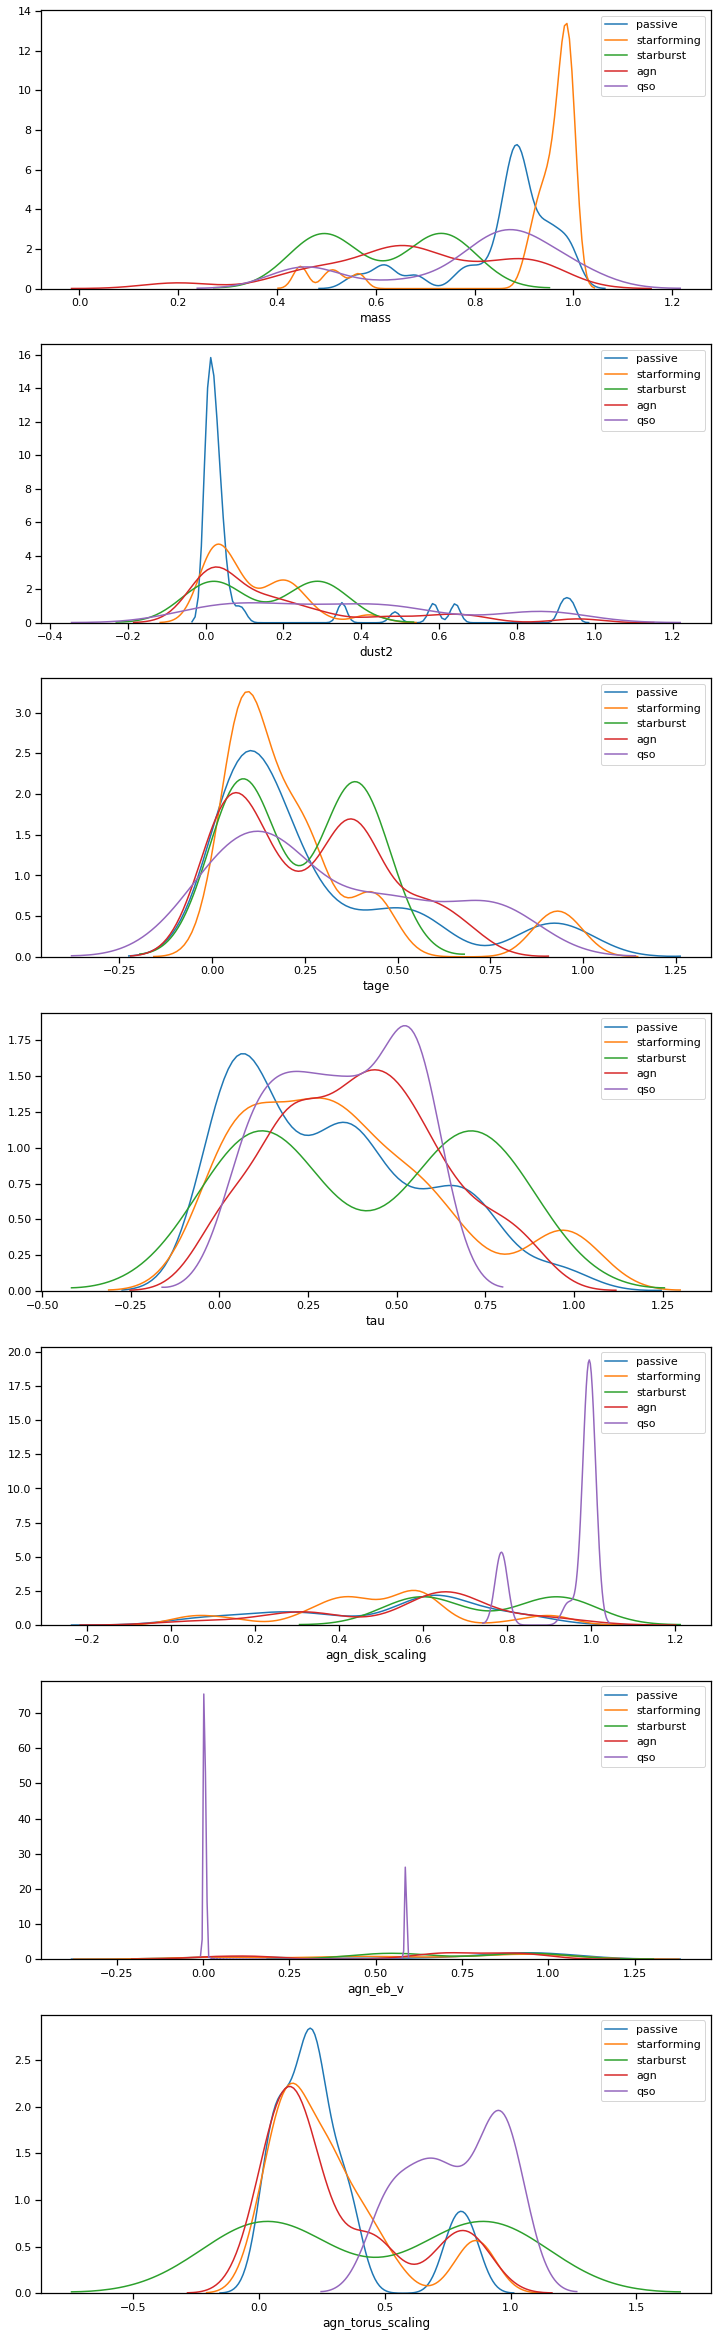

In [68]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in rf_classes:
        values = df[df['rf_class'] == galaxy_class][feature]
#         if feature in log_params:
#             values = np.log10(values)
#         print(values.shape)
        if len(values) > 0:
            sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')

In [69]:
# df = df[df['rf_class'] != 'agn']

In [70]:
from agnfinder import simulation_utils
from collections import OrderedDict

# a bit hacky - log* keys will be 10 ** within simulator function below
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0., 2.],  # not age of universe, as mistakenly done before...
    'tage': [0.001, 13.8],  # not 0->2, as mistakenly done before...might consider bringing the bounds a bit tighter
    'log_tau': [np.log10(.1), np.log10(30)],  # careful, this is log prior! >2, has very little effect
    'log_agn_mass': [-7, np.log10(15)],  # i.e. from 10**-7 to 15 (not 10**15!)
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})
param_dim = len(free_params.keys())


In [71]:
for galaxy in galaxies:
    galaxy['denormalised_samples'] = simulation_utils.denormalise_hypercube(galaxy['samples'], free_params)

In [72]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['denormalised_samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [73]:
df = raw_df

In [74]:
df[params].min()

mass                 6.169579e-01
dust2               -5.301388e+00
tage                -1.395395e+00
tau                  7.763023e-06
agn_disk_scaling     2.967490e-14
agn_eb_v            -1.873307e+00
agn_torus_scaling    4.048286e-14
dtype: float32

In [75]:
log_params = ['mass', 'tau', 'agn_disk_scaling', 'agn_torus_scaling']

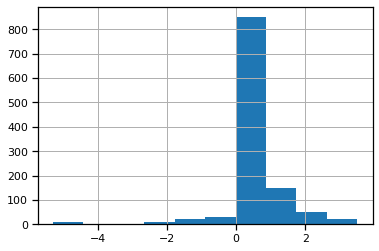

In [76]:
df['dust2'].hist()

(320,)
(290,)
(30,)
(220,)
(280,)
(0,)
(320,)
(290,)
(30,)
(220,)
(280,)
(0,)
(320,)
(290,)
(30,)
(220,)
(280,)
(0,)
(320,)
(290,)
(30,)
(220,)
(280,)
(0,)
(320,)
(290,)
(30,)
(220,)
(280,)
(0,)
(320,)
(290,)
(30,)
(220,)
(280,)
(0,)
(320,)
(290,)
(30,)
(220,)
(280,)
(0,)


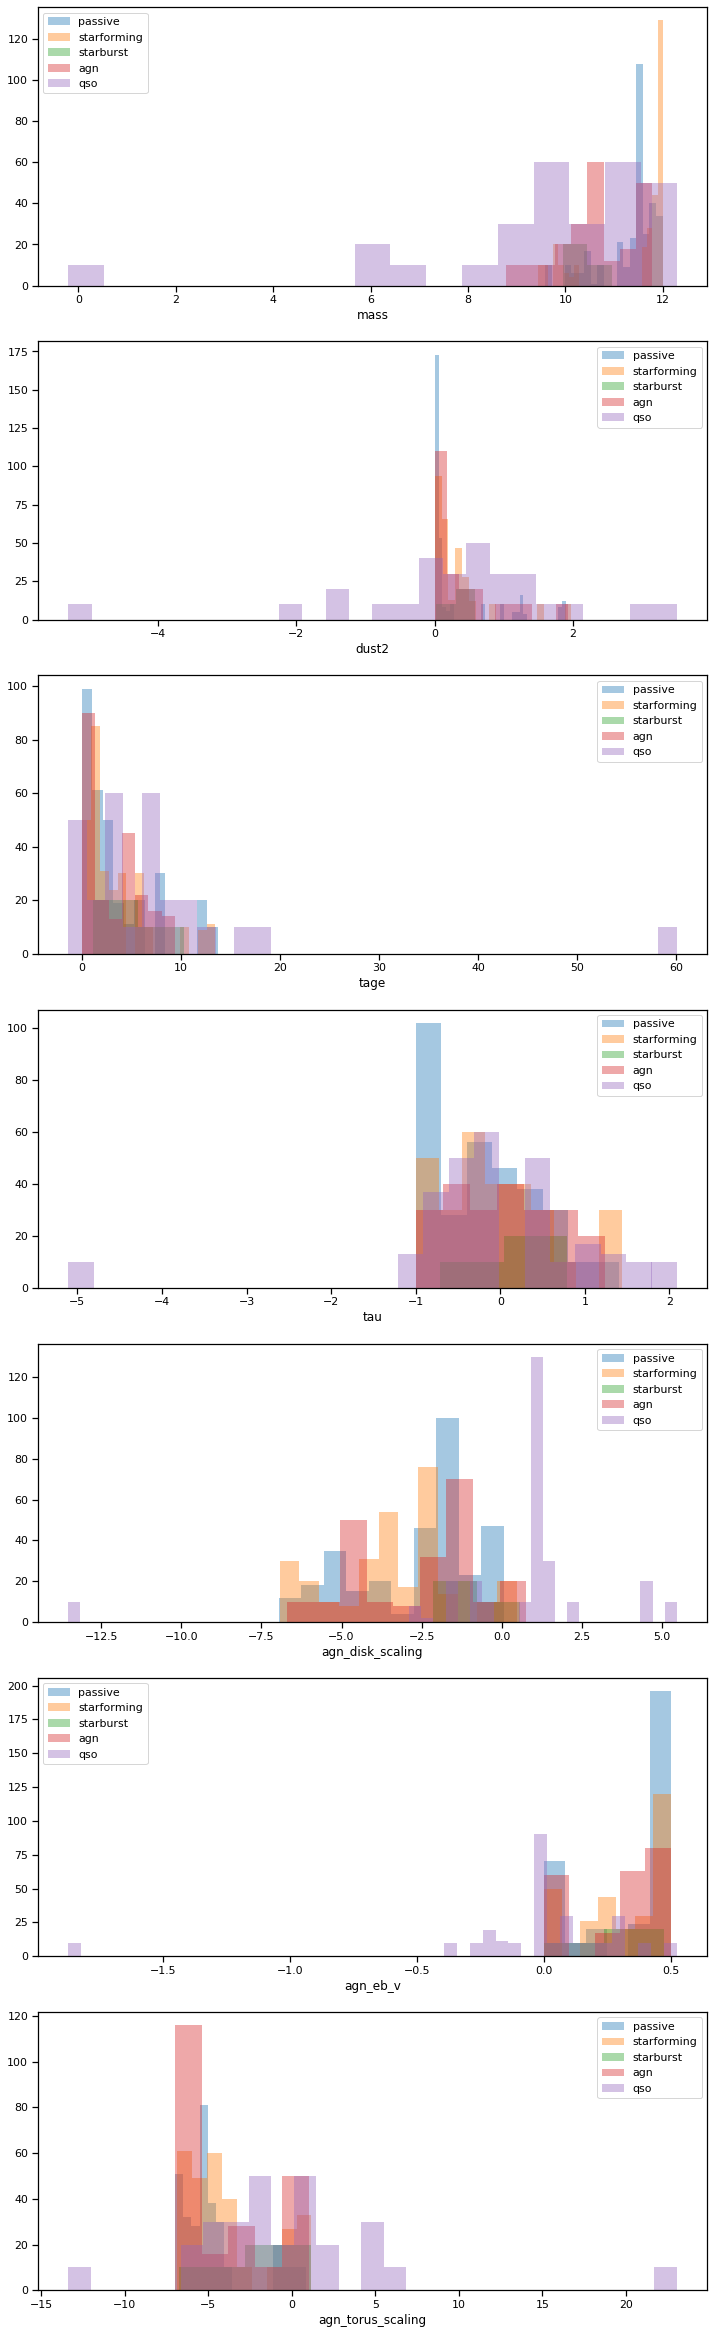

In [77]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in rf_classes:
        values = df[df['rf_class'] == galaxy_class][feature]
        if feature in log_params:
            values = np.log10(values)
        print(values.shape)
        if len(values) > 0:
            try:
                sns.distplot(values, label=galaxy_class, kde=False, ax=ax)
            except ValueError:
                print('Failed {} {}'.format(feature, galaxy_class))
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')